##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import os
import numpy as np
import math
import json

In [2]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [7]:
import json
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"
text_key = "preprocessedText"
docs = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        docs.append(d[text_key])

tdocs = []
with open(dataset_path + "DENV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tdocs.append(d[text_key])

        # Tokenize the documents.

        from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
for idx in range(len(tdocs)):
    tdocs[idx] = tokenizer.tokenize(tdocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
tdocs = [[token for token in doc if not token.isnumeric()] for doc in tdocs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
tdocs = [[token for token in doc if len(token) > 1] for doc in tdocs]

print(len(docs))
print(docs[0][:500])
print(len(tdocs))
print(tdocs[0][:500])

22996
['carbocisteine', 'inhibit', 'respiratory', 'syncytial', 'virus', 'infection', 'human', 'tracheal', 'epithelial', 'cell', 'it', 'be', 'suggest', 'carbocisteine', 'may', 'inhibit', 'RS', 'virus', 'infection', 'reduce', 'expression', 'icam', 'RS', 'virus', 'receptor', 'it', 'may', 'also', 'modulate', 'airway', 'inflammation', 'RSirus', 'infection']
8679
['vitro', 'effect', 'human', 'cathelicidin', 'antimicrobial', 'peptide', 'll', 'dengue', 'virus', 'type', 'vitro', 'experiment', 'silico', 'analysis', 'suggest', 'LL', 'inhibit', 'dengue', 'virus', 'type', 'DENV', 'infection', 'replication', 'Vero', 'e6', 'cell', 'bind', 'protein']


In [21]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)
bads = ["in", "it", "may", "also", "that", "which", "will", "not", "have", "use"]
dictionary.filter_tokens(bad_ids=[dictionary.token2id[tok] for tok in bads])

# Bag-of-words representation of the documents.
tr_corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(tr_corpus))
te_corpus = [dictionary.doc2bow(doc) for doc in tdocs]
print('Number of test documents: %d' % len(te_corpus))
print(te_corpus[500])

Number of unique tokens: 6268
Number of documents: 22996
Number of test documents: 8679
[(10, 1), (22, 1), (23, 1), (40, 2), (79, 1), (275, 1), (280, 1), (303, 1), (505, 1), (536, 2), (557, 1), (640, 1), (800, 1), (832, 1), (1058, 1), (1059, 1), (1061, 1), (1644, 1), (1706, 1), (1926, 1), (2657, 3), (3066, 1), (3848, 1)]


In [22]:
farr1 = []
for i in range(len(docs)):
    arr = [0] * len(dictionary)
    for j,_ in tr_corpus[i]:
        arr[j] = 1
    farr1.append(arr)
farr2 = []
for i in range(len(tdocs)):
    arr = [0] * len(dictionary)
    for j,_ in te_corpus[i]:
        arr[j] = 1
    farr2.append(arr)

In [23]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import tensorflow_decision_forests as tfdf

bsize = 300
larr1 = []
larr2 = []
with open(dataset_path + "ROTVRSV") as file:
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        larr1.append(int(d["label"]))
train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr1), 
                                               np.asarray(larr1))).batch(bsize)

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()
    for line in test_lines:
        d = json.loads(line)
        larr2.append(int(d["label"]))
test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(farr2),
                                              np.asarray(larr2))).batch(bsize)
print("Made datasets")

Made datasets


In [24]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=300, verbose=2, num_threads=3)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

<IPython.core.display.Javascript object>

Use /tmp/tmp5jq9yne6 as temporary training directory


Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 6268), dtype=int64)
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None


2023-07-16 18:30:21.764629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_5:0' shape=(None,) dtype=float32>), 'data:0.6': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_6:0' shape=(None,) dtype=float32>), 'data:0.7': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, t

Training dataset read in 0:00:42.531618. Found 22996 examples.
Training model...


[INFO 23-07-16 18:31:04.0956 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-16 18:31:04.0956 CEST kernel.cc:774] Collect training examples
[INFO 23-07-16 18:31:04.0956 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-16 18:31:04.1112 CEST kernel.cc:393] Number of batches: 77
[INFO 23-07-16 18:31:04.1112 CEST kernel.cc:394] Number of examples: 22996
[INFO 23-07-16 18:31:05.3091 CEST kernel.cc:794] Training dataset:
Number of records: 22996
Number of columns: 6269

Number of columns by type:
	NUMERICAL: 6268 (99.984%)
	CATEGORICAL: 1 (0.0159515%)

Columns:

NUMERICAL: 6268 (99.984%)
	1: "data:0.0" NUMERICAL mean:0.00395721 

[INFO 23-07-16 18:31:08.0795 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 6268 feature(s).
[INFO 23-07-16 18:31:12.6598 CEST random_forest.cc:802] Training of tree  1/300 (tree index:2) done accuracy:0.696872 logloss:10.9258
[INFO 23-07-16 18:31:18.0782 CEST random_forest.cc:802] Training of tree  11/300 (tree index:11) done accuracy:0.710033 logloss:3.44908
[INFO 23-07-16 18:31:22.8052 CEST random_forest.cc:802] Training of tree  21/300 (tree index:19) done accuracy:0.710477 logloss:1.76103
[INFO 23-07-16 18:31:27.4086 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.714255 logloss:1.17101
[INFO 23-07-16 18:31:33.0019 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.71856 logloss:1.01189
[INFO 23-07-16 18:31:37.5736 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.71382 logloss:0.926563
[INFO 23-07-16 18:31:43.1924 CEST random_forest.cc:802] Training of

Model trained in 0:02:44.424560
Compiling model...


2023-07-16 18:33:48.945703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [22996]
	 [[{{node Placeholder/_1}}]]


Model compiled.


In [25]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, batch_size=None)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

2023-07-16 18:36:28.443931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8679]
	 [[{{node Placeholder/_1}}]]


29/29 [==============================] - 65s 30ms/step - loss: 0.0000e+00 - accuracy: 0.8283
BinaryCrossentropyloss: 0.0
Accuracy: 0.8283212184906006


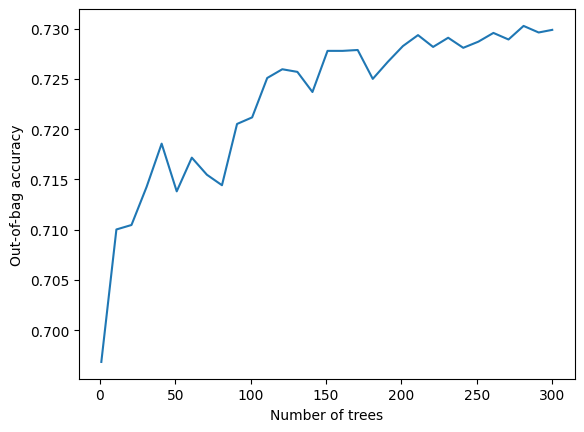

In [26]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag accuracy")
pass

In [27]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = larr2[i] == 1
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

29/29 [==============================] - 63s 29ms/step
cut: 0.25, acc: 0.8170296117064177, prec: 0.6040012702445221, rec: 0.847971466785555, f1: 0.7054896142433236
cut: 0.3, acc: 0.8464108768291277, prec: 0.6752696456086287, rec: 0.7815425769059295, f1: 0.7245298615416409
cut: 0.35, acc: 0.8610438990667127, prec: 0.7508466376390904, rec: 0.6919304502897905, f1: 0.7201856148491879
cut: 0.39999999999999997, acc: 0.8577025002880516, prec: 0.7985781990521327, rec: 0.6009808292465448, f1: 0.6858305774612057
cut: 0.44999999999999996, acc: 0.8476783039520682, prec: 0.8470233609645818, rec: 0.5011145786892555, f1: 0.6296918767507002
cut: 0.49999999999999994, acc: 0.8283212351653416, prec: 0.8877445932028837, rec: 0.3843067320552831, f1: 0.536403235843186
cut: 0.5499999999999999, acc: 0.8064293121327342, prec: 0.9182763744427934, rec: 0.2755238519839501, f1: 0.4238683127572016
cut: 0.5999999999999999, acc: 0.7854591542804471, prec: 0.9568345323741008, rec: 0.17788675880517166, f1: 0.30000000000

In [15]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for c in np.arange(0., .5, .05):
        s = 0
        t = 0
        for i in range(N):
            tru = test_cases[i]["label"] == '1'
            val = int((p[i]+0.005) * 100)
            pred = False
            if val > cut:
                pred = True
            elif val > 100*c:
                s = s+1
                if tru:
                    t = t+1
        print("c: {}, n = {}, tru: {}".format(c, s, t))

c: 0.0, n = 6525, tru: 378
c: 0.05, n = 6396, tru: 378
c: 0.1, n = 5885, tru: 377
c: 0.15000000000000002, n = 4983, tru: 376
c: 0.2, n = 4009, tru: 374
c: 0.25, n = 3139, tru: 368
c: 0.30000000000000004, n = 2379, tru: 351
c: 0.35000000000000003, n = 1765, tru: 323
c: 0.4, n = 1261, tru: 281
c: 0.45, n = 785, tru: 209
